In [81]:
# conda install pytorch torchvision -c pytorch


# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from bokeh.plotting import figure, output_file, show
from bokeh.themes import built_in_themes
from bokeh.io import curdoc, output_notebook
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn

In [2]:
# Check whether GPU is available and choose a device to run the model on
gpu_available = torch.cuda.is_available()
device_name = "cuda" if gpu_available else "cpu"
device = torch.device(device_name)

print(f"Using {device_name}")

Using cuda


In [3]:
class ExoplaNET_v1(nn.Module):
    def __init__(self, 
                 len_global_lightcurves = 2049, 
                 len_local_lightcurves = 257, 
                 len_secondary_lightcurves = 0, 
                 len_extra_parameters = 0,
                 len_fully_connected = 512,
                 input_channels = 1, 
                 output_classes = 2,
                 dropout = 0.05,
                 batchnorm = False,
                 augment = False,
                 pooling_type='max'):
        
        super().__init__()
        
        # Pooling dimensional reduction funciton. Order is number of poolings that the
        # column uses. Assumes that:   2*padding = kernel_size-1 and stride = 2
        def pooling_reduction(input_dim, order):
            if order == 1:
                output_dim = int(((input_dim - 1)/2 + 1)//1)
                return output_dim
            else:
                next_dim = int(((input_dim - 1)/2 + 1)//1)
                return pooling_reduction(next_dim, order-1)
        
        
        # General configuration:
        self.len_global_lightcurves    = len_global_lightcurves
        self.len_local_lightcurves     = len_local_lightcurves
        self.len_secondary_lightcurves = len_secondary_lightcurves
        
        self.len_extra_parameters = len_extra_parameters
        self.input_channels = input_channels
        
        self.len_total_input = (len_global_lightcurves + 
                                len_local_lightcurves + 
                                len_secondary_lightcurves +
                                len_extra_parameters)
        
        self.len_fully_connected = len_fully_connected
        self.output_classes = output_classes
        self.augment = augment
                                
        # Calculate the length of the vectors after the convolutional columns
        self.len_global_col     = pooling_reduction(self.len_global_lightcurves,    5) * 256
        self.len_local_col      = pooling_reduction(self.len_local_lightcurves,     2) *  32
        self.len_secondary_col  = pooling_reduction(self.len_secondary_lightcurves, 2) *  32
                                
        # Calculate the input size for the first fully connected layer
        self.len_fc_input = (self.len_global_col + 
                             self.len_local_col + 
                             self.len_secondary_col +
                             self.len_extra_parameters * self.input_channels)
        
                                
        # Layers for convolutional columns of the model
        # Layers with same config must be repeated because they will need different weights
        c = self.input_channels
        
        # Convolutions for global view column
        self.conv_5_16_g_a  = nn.Conv1d(  c,  16, kernel_size=5, stride=1, padding=2)
        self.conv_5_16_g_b  = nn.Conv1d( 16,  16, kernel_size=5, stride=1, padding=2)
        
        self.conv_5_32_g_a  = nn.Conv1d( 16,  32, kernel_size=5, stride=1, padding=2)
        self.conv_5_32_g_b  = nn.Conv1d( 32,  32, kernel_size=5, stride=1, padding=2)
        
        self.conv_5_64_g_a  = nn.Conv1d( 32,  64, kernel_size=5, stride=1, padding=2)
        self.conv_5_64_g_b  = nn.Conv1d( 64,  64, kernel_size=5, stride=1, padding=2)
        
        self.conv_5_128_g_a = nn.Conv1d( 64, 128, kernel_size=5, stride=1, padding=2)
        self.conv_5_128_g_b = nn.Conv1d(128, 128, kernel_size=5, stride=1, padding=2)
        
        self.conv_5_256_g_a = nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2)
        self.conv_5_256_g_b = nn.Conv1d(256, 256, kernel_size=5, stride=1, padding=2)
                                
        # Convolutions for local view column   
        self.conv_5_16_l_a  = nn.Conv1d(  c,  16, kernel_size=5, stride=1, padding=2)
        self.conv_5_16_l_b  = nn.Conv1d( 16,  16, kernel_size=5, stride=1, padding=2)
        
        self.conv_5_32_l_a  = nn.Conv1d( 16,  32, kernel_size=5, stride=1, padding=2)
        self.conv_5_32_l_b  = nn.Conv1d( 32,  32, kernel_size=5, stride=1, padding=2)

        # Convolutions for secondary view column   
        self.conv_5_16_s_a  = nn.Conv1d(  c,  16, kernel_size=5, stride=1, padding=2)
        self.conv_5_16_s_b  = nn.Conv1d( 16,  16, kernel_size=5, stride=1, padding=2)
        
        self.conv_5_32_s_a  = nn.Conv1d( 16,  32, kernel_size=5, stride=1, padding=2)
        self.conv_5_32_s_b  = nn.Conv1d( 32,  32, kernel_size=5, stride=1, padding=2)
                                
        # Pooling layers
        # These contain no parameters, so they can be shared
        if pooling_type == 'max':
            self.pool_5_2     = nn.MaxPool1d(5, stride=2, padding=2)
            self.pool_7_2     = nn.MaxPool1d(7, stride=2, padding=3)
        elif pooling_type == 'avg':
            self.pool_5_2     = nn.AvgPool1d(5, stride=2, padding=2)
            self.pool_7_2     = nn.AvgPool1d(7, stride=2, padding=3)
        
        # Batch normalization layers
        self.batchnorm = batchnorm
        
        self.bn_g = nn.BatchNorm1d(256)
        self.bn_l = nn.BatchNorm1d(32)
        self.bn_s = nn.BatchNorm1d(32)


        # Dropout laters
        self.drop = nn.Dropout(dropout)
        
        # Dense layers for classification of extracted features
        self.fc_512_a     = nn.Linear(self.len_fc_input, self.len_fully_connected)
        self.fc_512_b     = nn.Linear(self.len_fully_connected, self.len_fully_connected)
        self.fc_512_c     = nn.Linear(self.len_fully_connected, self.len_fully_connected)
        self.fc_512_d     = nn.Linear(self.len_fully_connected, self.len_fully_connected)
        
        self.fc_out       = nn.Linear(self.len_fully_connected, self.output_classes)
        
    def forward(self, xb):  # xb is of size (batch_size, input_channels, len_total_input)
        
        flip = False
        if self.augment:
            flip = np.random.choice([True, False])

        batch_size     = xb.size()[0]
        
        # Extract input of different columns for whole batch and all channels
        gb, lb, sb, eb = torch.split(xb, [self.len_global_lightcurves,
                                          self.len_local_lightcurves,
                                          self.len_secondary_lightcurves,
                                          self.len_extra_parameters],
                                     dim=2)
        
        if flip:
            gb = torch.flip(gb, [2])
            lb = torch.flip(lb, [2])
            sb = torch.flip(sb, [2])


        if min(gb.size()) > 0:  # Only run the column if the input exists
            # Convolutions for global view
            gb = F.relu(self.conv_5_16_g_a (gb))
            gb = F.relu(self.conv_5_16_g_b (gb))
            gb = self.pool_5_2(gb)
            gb = self.drop(gb)

            gb = F.relu(self.conv_5_32_g_a (gb))
            gb = F.relu(self.conv_5_32_g_b (gb))
            gb = self.pool_5_2(gb)
            gb = self.drop(gb)

            gb = F.relu(self.conv_5_64_g_a (gb))
            gb = F.relu(self.conv_5_64_g_b (gb))
            gb = self.pool_5_2(gb)
            gb = self.drop(gb)

            gb = F.relu(self.conv_5_128_g_a(gb))
            gb = F.relu(self.conv_5_128_g_b(gb))
            gb = self.pool_5_2(gb)
            gb = self.drop(gb)

            gb = F.relu(self.conv_5_256_g_a(gb))
            gb = F.relu(self.conv_5_256_g_b(gb))
            gb = self.pool_5_2(gb)
            gb = self.drop(gb)

            if self.batchnorm:
                gb = self.bn_g(gb)
        
        gb = torch.flatten(gb, 1, 2)  # Flatten channels and features but NOT batches
        
        if min(lb.size()) > 0:
            # Convolutions for local view
            lb = F.relu(self.conv_5_16_l_a (lb))
            lb = F.relu(self.conv_5_16_l_b (lb))
            lb = self.pool_7_2(lb)    
            lb = self.drop(lb)

            lb = F.relu(self.conv_5_32_l_a (lb))
            lb = F.relu(self.conv_5_32_l_b (lb))
            lb = self.pool_7_2(lb)
            lb = self.drop(lb)

            if self.batchnorm:
                lb = self.bn_l(lb)

        lb = torch.flatten(lb, 1, 2)
            

        if min(sb.size()) > 0:
            # Convolutions for secondary view
            sb = F.relu(self.conv_5_16_s_a (sb))
            sb = F.relu(self.conv_5_16_s_b (sb))
            sb = self.pool_7_2(sb)
            sb = self.drop(sb)

            sb = F.relu(self.conv_5_32_l_a (sb))
            sb = F.relu(self.conv_5_32_l_b (sb))
            sb = self.pool_7_2(sb)
            sb = self.drop(sb)

            if self.batchnorm:
                sb = self.bn_s(sb)
        
        sb = torch.flatten(sb, 1, 2)
                                
        # Reshape extra features
        eb = torch.flatten(eb, 1, 2)
                                
        # Concatenate results maintaining batch positioning in first dimension
        fb = torch.cat((gb, lb, sb, eb), dim=1)

        # Apply fully connected layers
        fb = F.relu(self.fc_512_a(fb))
        fb = self.drop(fb)
        fb = F.relu(self.fc_512_b(fb))
        fb = self.drop(fb)
        fb = F.relu(self.fc_512_c(fb))
        fb = self.drop(fb)
        fb = F.relu(self.fc_512_d(fb))

        # Output layer
        fb = self.fc_out(fb)
        
        return fb

In [4]:
# Load labelled data

project_folder = Path("*** PUT YOUR PROJECT FOLDER HERE ***")
data_folder = project_folder/"data"

X_filename = "X_fold_noCentroid_noNans.npy"
y_filename = "y_fold_noCentroid_noNans.npy"
z_filename = "z_fold_noCentroid_noNans.npy"

datanpy    = np.load(data_folder/X_filename)
labelsnpy  = np.load(data_folder/y_filename)
namesnpy   = np.load(data_folder/z_filename)


nof_planets  = (labelsnpy == 1).sum()  # Number of actual planets
nof_falsepos = (labelsnpy == 0).sum()  # Number of false positives

len_global_lightcurves = 2049  # Length of first column of input array, should be odd
len_local_lightcurves  =  257  # Length of second column of input array, should be odd
len_extra_parameters   =    0  # Length of extra parameters for the model input

X = torch.from_numpy(datanpy).float().unsqueeze(1).to(device, dtype=torch.float)
y = torch.from_numpy(labelsnpy).int().to(device, dtype=torch.long)

In [5]:
# Create an iterable dataset from the input and label tensors
dataset = TensorDataset(X, y)

# Perform the train/test/validation split
train_size = int(0.7 * len(y))
test_size  = int(0.2 * len(y))
val_size = len(y) - train_size - test_size
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(
                                             dataset, 
                                             [train_size, test_size, val_size])

In [6]:
# Choose a batch size and create a data loader from the dataset

bs = 50  # Batch size
train_dl = DataLoader(train_dataset, batch_size=bs, shuffle=True)  # Needs shuffling to prevent correlation between batches
test_dl  = DataLoader(test_dataset,  batch_size=bs * 2)  # Test can use higher batch size because it needs less memory
valid_dl = DataLoader(val_dataset, batch_size=bs * 2)  # Validation can use higher batch size because it needs less memory

In [7]:
model_folder = project_folder/"models"

dropout       = 0.0
batchnorm     = True
loss_func = F.cross_entropy

model = ExoplaNET_v1(dropout = dropout,
                     batchnorm = batchnorm,
                     augment = False
                    ).to(device)
model.load_state_dict(torch.load(model_folder/"EXOPLANETv1_985.pt"))
model.eval()

ExoplaNET_v1(
  (conv_5_16_g_a): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv_5_16_g_b): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv_5_32_g_a): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv_5_32_g_b): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv_5_64_g_a): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv_5_64_g_b): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv_5_128_g_a): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv_5_128_g_b): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv_5_256_g_a): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv_5_256_g_b): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv_5_16_l_a): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv_5_16_l_b): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv_5_32_l_a): Conv1d(16,

In [8]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    # If an optimizer is used, then run as if trianing, otherwise as if testing
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [9]:
def acc_batch(model, xb, yb):
    max_vals, max_indices = torch.max(model(xb), 1)  # Maximum along output dimension (0 is batch dimension)
    accuracy = float((max_indices == yb).sum().float()/len(yb))
    return accuracy, len(yb)

In [10]:
# Test model on validation data
valid_dl = DataLoader(val_dataset, batch_size=50)

val_losses = [loss_batch(model, loss_func, xb, yb, opt=None)[0] for xb, yb in valid_dl]
val_accurs = [acc_batch(model, xb, yb)[0] for xb, yb in valid_dl]
print(f"Validation cross entropy loss: {sum(val_losses)/len(val_losses)}")
print(f"Validation accuracy: {sum(val_accurs)/len(val_accurs)}")

Validation cross entropy loss: 0.1579362486799558
Validation accuracy: 0.9519999821980795


In [11]:
valid_dl = DataLoader(val_dataset, batch_size=1)
val_results, val_labes = [], []
for xb, yb in valid_dl:
    val_results.append(softmax(model(xb).cpu().detach().numpy()))
    val_labes.append(yb.cpu().detach().numpy())
val_results = np.concatenate(val_results)[:, 1]
val_labels   = np.concatenate(val_labes)

val_asig = np.stack([val_results, val_labels], axis=1)

In [12]:
val_diff = np.abs(val_asig[:, 0] - val_asig[:, 1])

In [13]:
precision = []
recall = []
truths = val_asig[:, 1] == 1.
num_truths = truths.sum()
for threshold in np.linspace(0, 1, 100001)[:-1]:
    assignations = val_asig[:, 0] > threshold
    num_positives = assignations.sum()
    true_positives = (assignations & truths)
    num_true_positives = true_positives.sum()
    
    precision.append(num_true_positives / num_positives if num_positives > 0 else 1)
    recall.append(num_true_positives / num_truths if num_truths > 0 else 1)

In [413]:
def auc_calculator(assignations, samples = 1e5):
    """Calculates the probability that a randomly chosen
    planet scores higher in the model than a randomly 
    chosen false positive.
    """
    trues = assignations[:,0][assignations[:,1] == 1]
    falses = assignations[:,0][assignations[:,1] == 0]
    successes = 0
    for sample in range(int(samples)):
        true_sample = np.random.choice(trues)
        false_sample = np.random.choice(falses)
        if true_sample > false_sample:
            successes += 1
    return successes / samples

In [414]:
auc_calculator(val_asig)

0.98495

Text(0, 0.5, 'Precision')

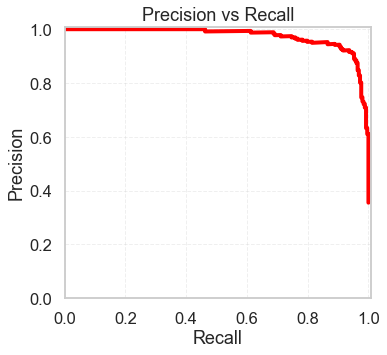

In [418]:
darkmode = False

if darkmode:
    sns.set(style="ticks", context="talk")
    plt.style.use("dark_background")
else:
    sns.set_style("whitegrid")

fig = plt.figure(figsize=(5.5, 5))
ax = plt.subplot(111)

ax.plot(recall, precision, color="red", linewidth=4)
ax.set_xlim((0,1.01))
ax.set_ylim((0,1.01))

ax.grid(True, alpha=0.3, ls='--', lw=1)

ax.set_title("Precision vs Recall")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")


In [419]:
def plot_confusion_matrix(val_asig, threshold, mode):
    import pandas as pd
    assigned = val_asig[:, 0] > threshold
    truths = val_asig[:, 1]
    
    array = np.array([[(assigned == True) & (truths == True),  (assigned == False) & (truths == True) ],
                      [(assigned == True) & (truths == False), (assigned == False) & (truths == False)]]).sum(axis=2)
    
    array = array/len(assigned)
    
    matrix = pd.DataFrame(array, index = ["Planet", "Not planet"],
                                 columns = ["Planet", "Not planet"])
    
    matrix.index.name = 'Actual'
    matrix.columns.name = 'Predicted'
    
    if mode:
        sns.set(style="ticks", context="talk")
        plt.style.use("dark_background")
    else:
        sns.set_style("whitegrid")
    
    plt.figure(figsize = (4,4))
    sns.heatmap(matrix, annot=True, square=True, fmt=".1%")


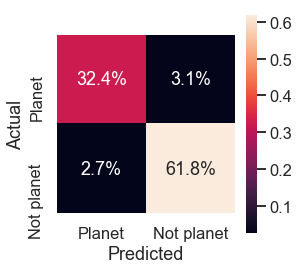

In [420]:
plot_confusion_matrix(val_asig, 0.6, darkmode)

Plot labelled lightcurves acording to results

In [347]:
def plot_lightcurves_labelled(tensor, status="", object_name="", color="orange", mode="darkmode", ylims=(-1.1,0.6), title=""):
    if status == 1:
        label = "planet"
    elif status == 0:
        label = "false positive"
    else:
        label = ""
    
    hfont = {'fontname':'Arial'}

    
    if mode == "darkmode":
        sns.set(style="ticks", context="talk")
        plt.style.use("dark_background")
    else:
        sns.set_style("whitegrid")
        
    glob_lc = tensor[:len_global_lightcurves].cpu().numpy().flatten()
    loc_lc = tensor[len_global_lightcurves:].cpu().numpy().flatten()

    fig1 = plt.figure(figsize=(16, 4))
    ax1 = fig1.add_subplot(121)

    ax1.scatter(np.linspace(0, 1, len_global_lightcurves), 
               glob_lc, 
               color=color, s=6)
    ax1.set_xlim((0,1))
    ax1.set_ylim(ylims)
    ax1.grid(True, alpha=0.3, ls='--', lw=1)

    ax1.title.set_text('Global folded lightcurve')
    #ax1.set_title(f"Global folded lightcurve for {object_name}", **hfont)
    ax1.set_xlabel("Time normalized to period", **hfont)
    ax1.set_ylabel("Normalized light intensity", **hfont)
    
    #plt.show()
    
    #fig2 = plt.figure(figsize=(8, 4))
    ax2 = fig1.add_subplot(122)

    ax2.scatter(np.linspace(0, 1, len_local_lightcurves), 
               loc_lc, 
               color=color, s=6)
    ax2.set_xlim((0,1))
    ax2.set_ylim(ylims)
    ax2.grid(True, alpha=0.3, ls='--', lw=1)

    ax2.title.set_text('Local folded lightcurve')
    #ax2.set_title(f"Local folded lightcurve for {object_name}", **hfont)
    ax2.set_xlabel("Time normalized to transit", **hfont)
    #ax2.set_ylabel("Normalized light intensity", **hfont)
    
    plt.suptitle(title, y=1.05)
    plt.show()

In [431]:
def plt_lclab(num):
    if df_asig.Label[num] == 1:
        title = "Confirmed Planet"
    elif df_asig.Label[num] == 0:
        title = "False Positive"
    plot_lightcurves_labelled(X_val[num], status="", object_name="", color="blue", mode="normal", 
                          title=f"{title}, assigned {df_asig.Output[num]:.5e}")

In [427]:
df_asig = pd.DataFrame(val_asig, columns=["Output", "Label"])
df_best_true_positives = df_asig[df_asig.Label==1].sort_values("Output", ascending=False).head()
df_best_true_negatives = df_asig[df_asig.Label==0].sort_values("Output", ascending=True).head()
df_worst_false_positives = df_asig[df_asig.Label==1].sort_values("Output", ascending=True).head()
df_worst_false_negatives = df_asig[df_asig.Label==0].sort_values("Output", ascending=False).head()

In [428]:
X_val = [xb.flatten() for xb, yb in valid_dl]

Plot best true positives

In [429]:
df_best_true_positives

,Output,Label
106,0.990642,1.0
509,0.988241,1.0
43,0.988018,1.0
528,0.987963,1.0
695,0.987529,1.0


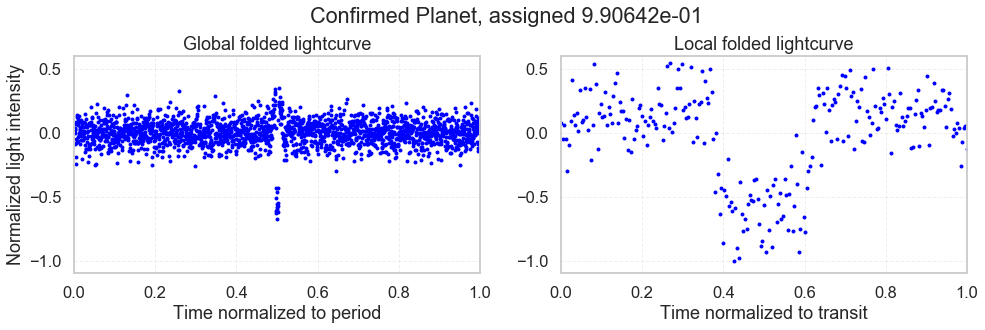

In [432]:
plt_lclab(106)

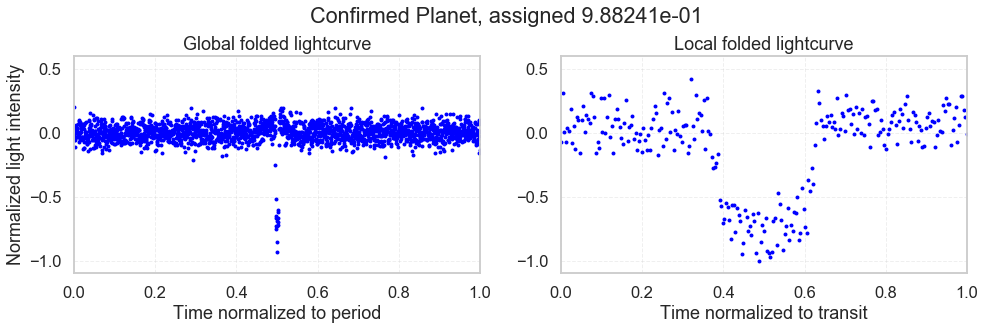

In [433]:
plt_lclab(509)

Plot best true negatives

In [434]:
df_best_true_negatives

,Output,Label
644,8.300879e-08,0.0
137,1.093707e-07,0.0
121,6.072337e-07,0.0
377,7.070835e-07,0.0
687,1.733689e-06,0.0


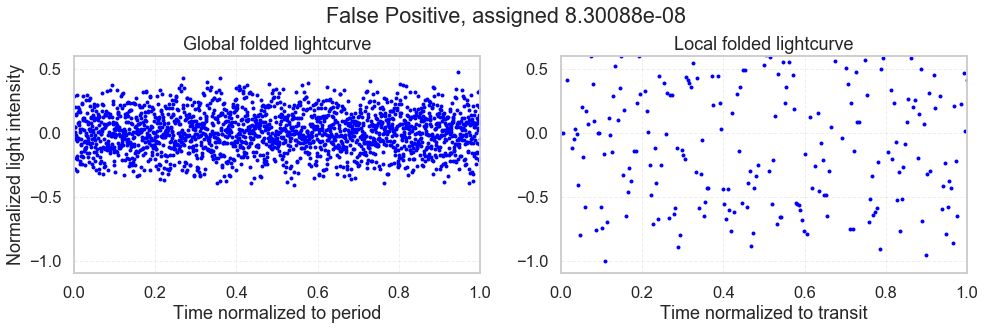

In [435]:
plt_lclab(644)

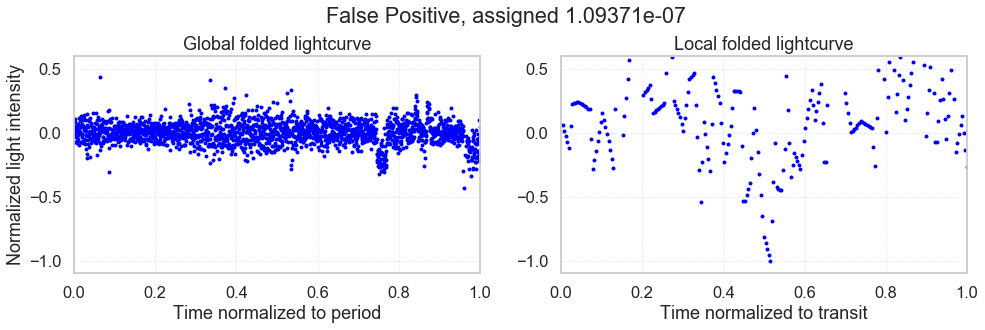

In [436]:
plt_lclab(137)

Plot worst false positives

In [437]:
df_worst_false_positives

,Output,Label
313,0.049122,1.0
379,0.056430,1.0
429,0.098372,1.0
238,0.115826,1.0
625,0.127277,1.0


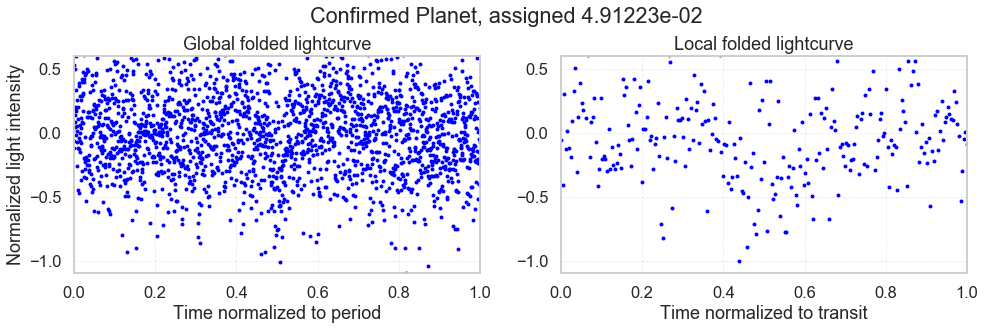

In [438]:
plt_lclab(313)

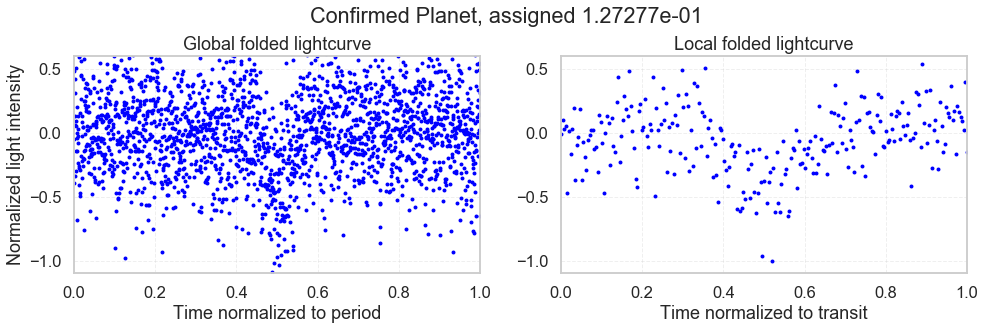

In [439]:
plt_lclab(625)

Plot worst false negatives

In [440]:
df_worst_false_negatives

,Output,Label
410,0.946734,0.0
481,0.920406,0.0
14,0.883129,0.0
95,0.878576,0.0
114,0.868236,0.0


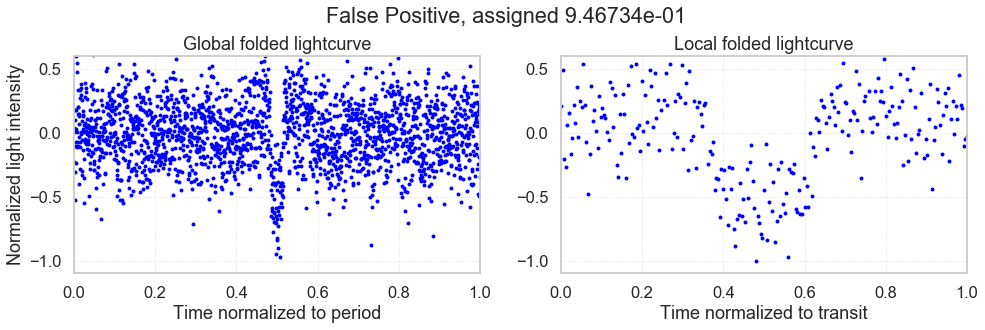

In [441]:
plt_lclab(410)

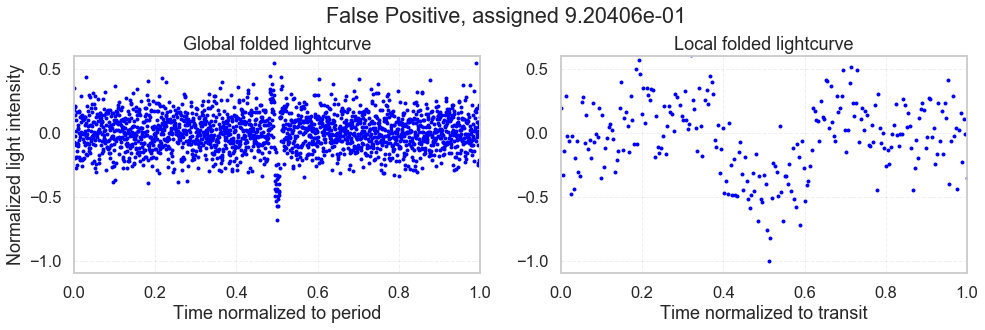

In [442]:
plt_lclab(481)

In [46]:
# Load unlabelled data

X_filename_ul = "X_fold_noCentroid_unlabelled_noNans.npy"
z_filename_ul = "z_fold_noCentroid_unlabelled_noNans.npy"

ul_datanpy    = np.load(data_folder/X_filename_ul)
ul_namesnpy   = np.load(data_folder/z_filename_ul)

len_global_lightcurves = 2049  # Length of first column of input array, should be odd
len_local_lightcurves  =  257  # Length of second column of input array, should be odd
len_extra_parameters   =    0  # Length of extra parameters for the model input

Xul = torch.from_numpy(ul_datanpy).float().unsqueeze(1).to(device, dtype=torch.float)

In [47]:
ul_dataset = TensorDataset(Xul)
ul_dataloader = DataLoader(ul_dataset, batch_size=1, shuffle=False)

In [50]:
# Run model on unlabelled data
ul_results = []
for xb, in ul_dataloader:
    ul_results.append(softmax(model(xb).cpu().detach().numpy()))
ul_results = np.concatenate(ul_results)[:, 1]

(array([871., 278., 163., 120., 103.,  94., 104., 143., 199., 304.]),
 array([1.1331470e-10, 9.9402241e-02, 1.9880448e-01, 2.9820672e-01,
        3.9760897e-01, 4.9701121e-01, 5.9641343e-01, 6.9581568e-01,
        7.9521793e-01, 8.9462018e-01, 9.9402243e-01], dtype=float32),
 <a list of 10 Patch objects>)

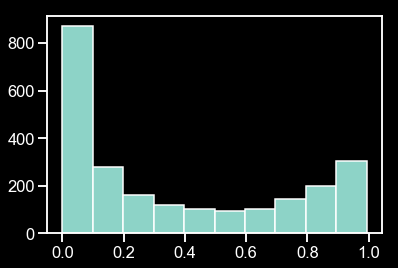

In [49]:
plt.hist(ul_results)

In [60]:
ul_assignations = pd.DataFrame(np.stack([ul_namesnpy, ul_results]).transpose(), columns=["Identifier", "Predicted value"])
ul_assignations["Predicted value"] = pd.to_numeric(ul_assignations["Predicted value"])

(array([871., 278., 163., 120., 103.,  94., 104., 143., 199., 304.]),
 array([1.13314700e-10, 9.94022401e-02, 1.98804480e-01, 2.98206720e-01,
        3.97608960e-01, 4.97011200e-01, 5.96413440e-01, 6.95815680e-01,
        7.95217920e-01, 8.94620160e-01, 9.94022400e-01]),
 <a list of 10 Patch objects>)

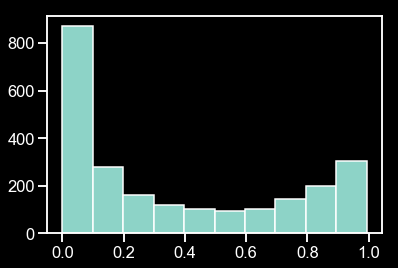

In [415]:
plt.hist(ul_assignations["Predicted value"])

In [76]:
# Get highest values (likeliest planets)
ul_assignations.sort_values(by="Predicted value", ascending=False)

,Identifier,Predicted value
52,K01206.01,9.940224e-01
237,K01861.01,9.926935e-01
1757,K05851.01,9.920542e-01
210,K01901.01,9.919294e-01
30,K01175.02,9.915577e-01
...,...,...
1458,K05254.01,1.736787e-06
2117,K07231.02,1.124600e-06
1343,K05033.01,1.975928e-07
29,K01174.01,1.357386e-08


In [93]:
# Get lowest values (likeliest NOT planets)
ul_assignations.sort_values(by="Predicted value", ascending=True)

,Identifier,Predicted value
1259,K03722.01,1.133147e-10
29,K01174.01,1.357386e-08
1343,K05033.01,1.975928e-07
2117,K07231.02,1.124600e-06
1458,K05254.01,1.736787e-06
...,...,...
30,K01175.02,9.915577e-01
210,K01901.01,9.919294e-01
1757,K05851.01,9.920542e-01
237,K01861.01,9.926935e-01


In [231]:
def plot_lightcurve_old(tensor, status="", object_name="", color="orange", mode="darkmode", ylims=(-1.1,0.6)):
    if status == 1:
        label = "planet"
    elif status == 0:
        label = "false positive"
    else:
        label = ""
    
    hfont = {'fontname':'Arial'}

    
    if mode == "darkmode":
        sns.set(style="ticks", context="talk")
        plt.style.use("dark_background")
    else:
        sns.set_style("whitegrid")
        
    glob_lc = tensor[0, :len_global_lightcurves].cpu().numpy().flatten()
    loc_lc = tensor[0, len_global_lightcurves:].cpu().numpy().flatten()

    fig1 = plt.figure(figsize=(8, 4))
    ax1 = plt.subplot(111)

    ax1.scatter(np.linspace(0, 1, len_global_lightcurves), 
               glob_lc, 
               color=color, s=6)
    ax1.set_xlim((0,1))
    ax1.set_ylim(ylims)
    ax1.grid(True, alpha=0.3, ls='--', lw=1)

    ax1.set_title(f"Global folded lightcurve for {object_name}", **hfont)
    ax1.set_xlabel("Time normalized to period", **hfont)
    ax1.set_ylabel("Normalized light intensity", **hfont)
    
    plt.show()
    
    fig2 = plt.figure(figsize=(8, 4))
    ax2 = plt.subplot(111)

    ax2.scatter(np.linspace(0, 1, len_local_lightcurves), 
               loc_lc, 
               color=color, s=6)
    ax2.set_xlim((0,1))
    ax2.set_ylim(ylims)
    ax2.grid(True, alpha=0.3, ls='--', lw=1)

    ax2.set_title(f"Local folded lightcurve for {object_name}", **hfont)
    ax2.set_xlabel("Time normalized to transit", **hfont)
    ax2.set_ylabel("Normalized light intensity", **hfont)
    
    plt.show()

In [393]:
def plot_lightcurves(tensor, status="", color="orange", mode="darkmode", ylims=(-1.1,0.6), title=""):
    if status == 1:
        label = "planet"
    elif status == 0:
        label = "false positive"
    else:
        label = ""
    
    hfont = {'fontname':'Arial'}

    
    if mode == "darkmode":
        sns.set(style="ticks", context="talk")
        plt.style.use("dark_background")
    else:
        sns.set_style("whitegrid")
        
    glob_lc = tensor[:len_global_lightcurves].cpu().numpy().flatten()
    loc_lc = tensor[len_global_lightcurves:].cpu().numpy().flatten()

    fig1 = plt.figure(figsize=(16, 4))
    ax1 = fig1.add_subplot(121)

    ax1.scatter(np.linspace(0, 1, len_global_lightcurves), 
               glob_lc, 
               color=color, s=6)
    ax1.set_xlim((0,1))
    ax1.set_ylim(ylims)
    ax1.grid(True, alpha=0.3, ls='--', lw=1)

    ax1.title.set_text('Global folded lightcurve')
    #ax1.set_title(f"Global folded lightcurve for {object_name}", **hfont)
    ax1.set_xlabel("Time normalized to period", **hfont)
    ax1.set_ylabel("Normalized light intensity", **hfont)
    
    #plt.show()
    
    #fig2 = plt.figure(figsize=(8, 4))
    ax2 = fig1.add_subplot(122)

    ax2.scatter(np.linspace(0, 1, len_local_lightcurves), 
               loc_lc, 
               color=color, s=6)
    ax2.set_xlim((0,1))
    ax2.set_ylim(ylims)
    ax2.grid(True, alpha=0.3, ls='--', lw=1)

    ax2.title.set_text('Local folded lightcurve')
    #ax2.set_title(f"Local folded lightcurve for {object_name}", **hfont)
    ax2.set_xlabel("Time normalized to transit", **hfont)
    #ax2.set_ylabel("Normalized light intensity", **hfont)
    
    plt.suptitle(title, y=1.05)
    plt.show()

In [443]:
def plt_lcunlab(num, ylims=(-1.1,0.6)):
    identifier = ul_assignations['Identifier'][num]
    output = ul_assignations['Predicted value'][num]
    tit = f"{identifier}, assigned {float(output):.5e}"
    plot_lightcurves(Xul[num].flatten(), status="", color="blue", mode="normal", title=tit, ylims=ylims)

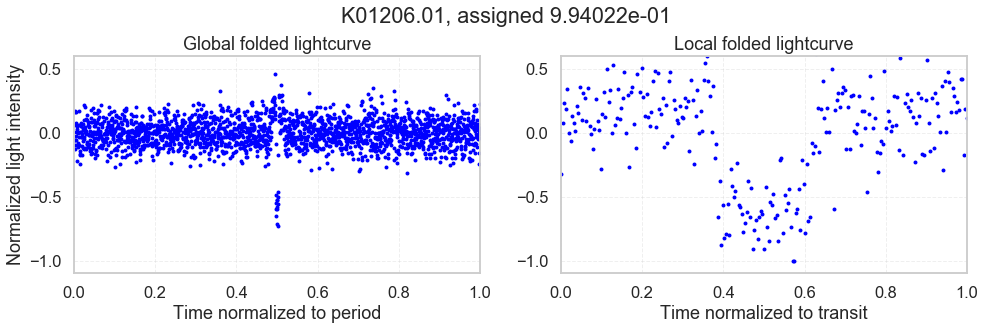

In [444]:
plt_lcunlab(52)

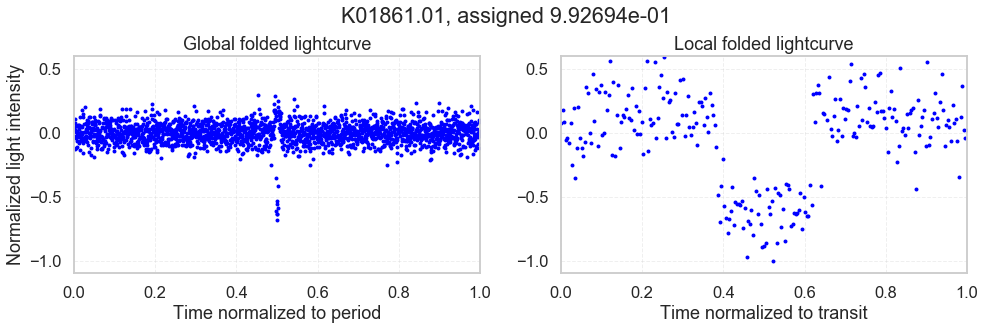

In [445]:
plt_lcunlab(237)

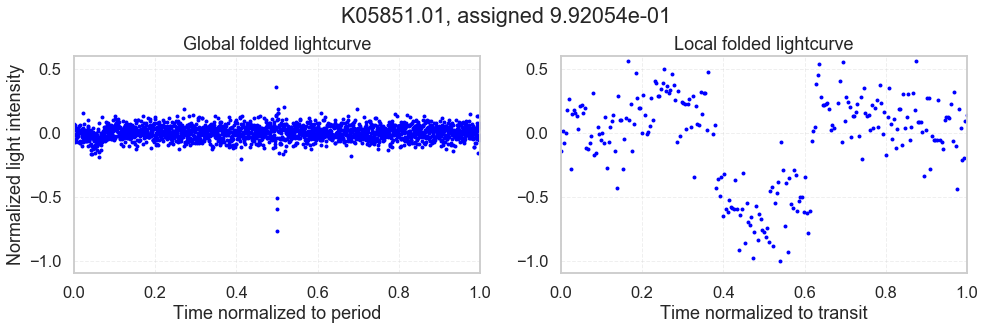

In [446]:
plt_lcunlab(1757)

Plots for not likely planets

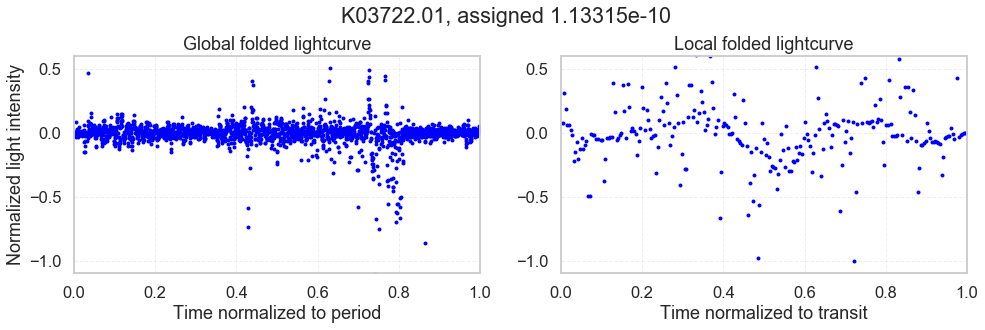

In [447]:
plt_lcunlab(1259)

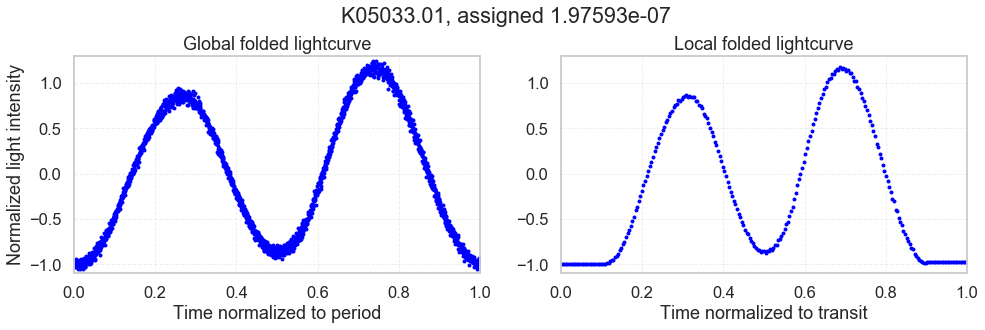

In [448]:
plt_lcunlab(1343, ylims=(-1.1, 1.3))

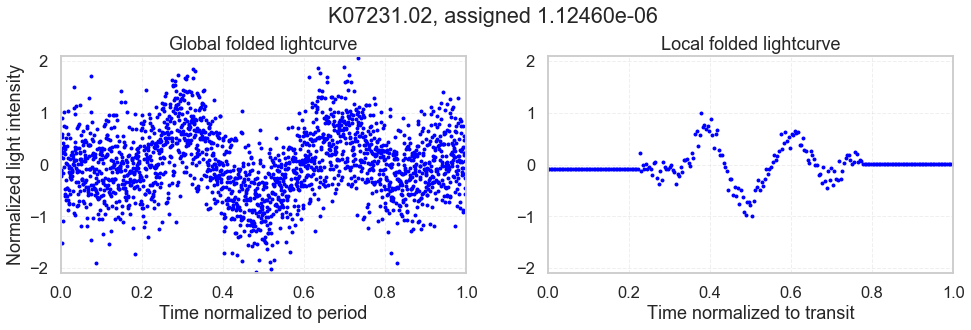

In [449]:
plt_lcunlab(2117, ylims=(-2.1, 2.1))

In [450]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

['C:\\WINDOWS\\Fonts\\verdanaz.ttf',
 'C:\\Windows\\Fonts\\ANTQUAI.TTF',
 'C:\\Windows\\Fonts\\TCMI____.TTF',
 'C:\\Windows\\Fonts\\SCHLBKBI.TTF',
 'C:\\WINDOWS\\Fonts\\BRUSHSCI.TTF',
 'C:\\Windows\\Fonts\\BRLNSDB.TTF',
 'C:\\Windows\\Fonts\\Candara.ttf',
 'C:\\WINDOWS\\Fonts\\BELLI.TTF',
 'C:\\WINDOWS\\Fonts\\LeelawUI.ttf',
 'C:\\Windows\\Fonts\\CALIFR.TTF',
 'C:\\Windows\\Fonts\\ONYX.TTF',
 'C:\\WINDOWS\\Fonts\\gadugib.ttf',
 'C:\\WINDOWS\\Fonts\\SNAP____.TTF',
 'C:\\WINDOWS\\Fonts\\BASKVILL.TTF',
 'C:\\Windows\\Fonts\\simsunb.ttf',
 'C:\\Windows\\Fonts\\ITCKRIST.TTF',
 'C:\\Windows\\Fonts\\COOPBL.TTF',
 'C:\\WINDOWS\\Fonts\\malgun.ttf',
 'C:\\WINDOWS\\Fonts\\MISTRAL.TTF',
 'C:\\Windows\\Fonts\\GARA.TTF',
 'C:\\WINDOWS\\Fonts\\segoeuii.ttf',
 'C:\\WINDOWS\\Fonts\\palabi.ttf',
 'C:\\WINDOWS\\Fonts\\REFSPCL.TTF',
 'C:\\Windows\\Fonts\\AGENCYB.TTF',
 'C:\\WINDOWS\\Fonts\\VINERITC.TTF',
 'C:\\Windows\\Fonts\\MISTRAL.TTF',
 'C:\\WINDOWS\\Fonts\\comicz.ttf',
 'C:\\WINDOWS\\Fonts\\TCBI____.